# 04 - Supervised Learning - Classification Models
This notebook trains and evaluates multiple classification models: Logistic Regression, Decision Tree, Random Forest, and SVM.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Load raw data; build target. Preprocessing will be fit on training data inside pipelines (avoid leakage)
DATA_PATH = '../data/processed.cleveland.data'
COLUMNS = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]
df = pd.read_csv(DATA_PATH, header=None, names=COLUMNS, na_values=['?'])
df['target'] = (df['num'] > 0).astype(int)
df = df.drop('num', axis=1)

print('Dataset shape:', df.shape)
df.head()

Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [9]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)
print('Class distribution in training:', y_train.value_counts())

Training set size: (242, 13)
Test set size: (61, 13)
Class distribution in training: 0    131
1    111
Name: target, dtype: int64


In [10]:
# Define preprocessing to be fit only on training data (avoid leakage)
NUMERIC_FEATURES = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
CATEGORICAL_FEATURES = ['cp', 'restecg', 'slope', 'ca', 'thal']
BINARY_FEATURES = ['sex', 'fbs', 'exang']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, NUMERIC_FEATURES + BINARY_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
])

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = []

In [11]:
# Create and evaluate model pipelines
for name, model in models.items():
    print(f'Training {name}...')
    
    # Create the full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    models[name] = pipeline  # Replace the model with the full pipeline
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })
    
    print(f'{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}')

Training Logistic Regression...
Logistic Regression - Accuracy: 0.8852, Precision: 0.8387, Recall: 0.9286, F1: 0.8814, ROC AUC: 0.9643
Training Decision Tree...
Decision Tree - Accuracy: 0.8033, Precision: 0.7222, Recall: 0.9286, F1: 0.8125, ROC AUC: 0.8128
Training Random Forest...
Random Forest - Accuracy: 0.8525, Precision: 0.8065, Recall: 0.8929, F1: 0.8475, ROC AUC: 0.9443
Training SVM...
SVM - Accuracy: 0.9016, Precision: 0.8438, Recall: 0.9643, F1: 0.9000, ROC AUC: 0.9600


In [12]:
# Display results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC AUC', ascending=False)
print('\nModel Performance Summary:')
print(results_df)


Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0  Logistic Regression  0.885246   0.838710  0.928571  0.881356  0.964286
3                  SVM  0.901639   0.843750  0.964286  0.900000  0.959957
2        Random Forest  0.852459   0.806452  0.892857  0.847458  0.944264
1        Decision Tree  0.803279   0.722222  0.928571  0.812500  0.812771


In [13]:
# Save results
metrics_path = '../results/evaluation_metrics.txt'
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
with open(metrics_path, 'a', encoding='utf-8') as f:
    f.write('=== Baseline Model Performance ===\n')
    f.write(results_df.to_string(index=False))
    f.write('\n\n')
print(f'Results written to {metrics_path}')

Results written to ../results/evaluation_metrics.txt


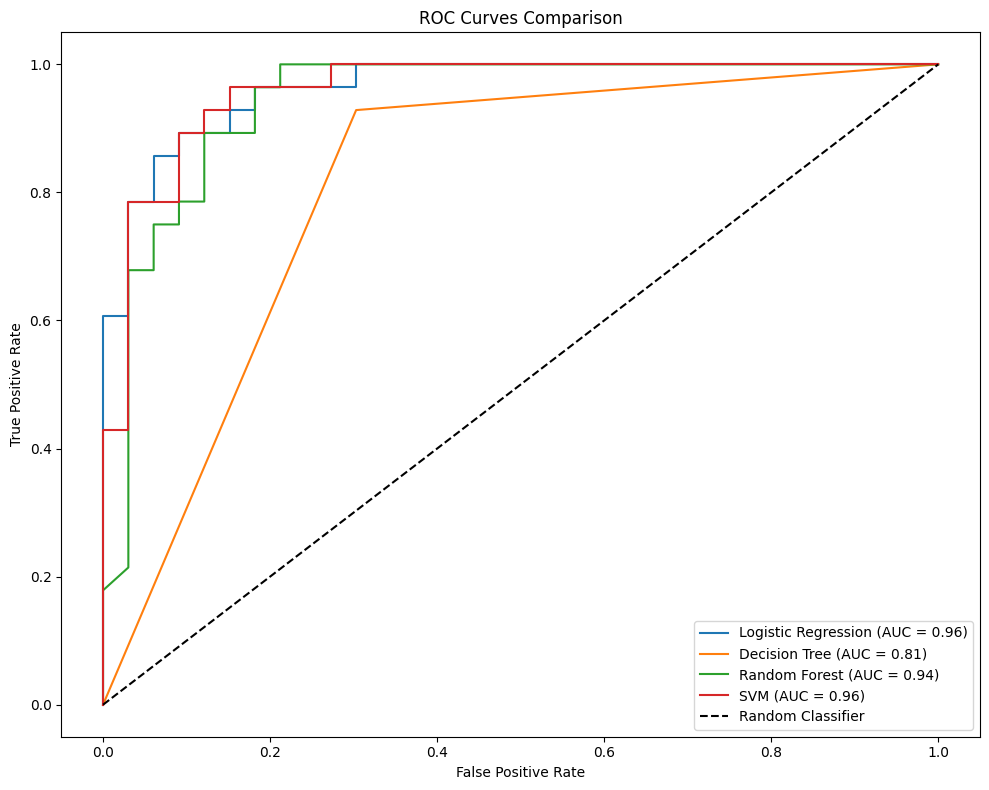

In [14]:
# ROC Curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.tight_layout()
plt.show()